In [7]:
import pandas as pd

df = pd.read_csv("/work/a06/tsuda/2025_master_Tsuda/master_research/keiba/train_raw.csv")


# 着順が1位なら１，それ以外なら０に設定（目的関数の設定）

In [8]:
import pandas as pd

# 着順を数値に変換（中止・除外などは NaN になる）
df["着 順_num"] = pd.to_numeric(df["着 順"], errors="coerce")

# 3着以内なら1、それ以外（NaN含む）は0
df["y_place"] = (df["着 順_num"] == 1).fillna(False).astype(int)


In [9]:
# ===== Step 3: 特徴量（出走前にわかるものだけ） =====

# まず使う列を固定（ミニマム）
features = ["枠 番", "馬 番", "斤量", "馬体重", "人 気", "jockey_id", "調教師"]
cat_features = ["jockey_id", "調教師"]

# 必要な列があるか確認（なければここで止める）
missing = [c for c in (["race_id"] + features + ["y_place"]) if c not in df.columns]
if missing:
    raise ValueError(f"CSVに必要な列がありません: {missing}")

# X, y, groups を作る
X = df[features].copy()
y = df["y_place"].copy()
groups = df["race_id"].copy()

# 型と欠損を整える
for c in features:
    if c in cat_features:
        X[c] = X[c].fillna("UNKNOWN").astype("category")
    else:
        X[c] = pd.to_numeric(X[c], errors="coerce").fillna(-1)

print("X shape:", X.shape)
print("y mean:", y.mean())
print("n_races:", groups.nunique())


X shape: (47122, 7)
y mean: 0.0723229064980264
n_races: 3402


# 学習、保存

In [10]:
models = []
import lightgbm as lgb
import numpy as np
from sklearn.model_selection import GroupKFold
from sklearn.metrics import log_loss

params = {
    "objective": "binary",
    "metric": "binary_logloss",
    "learning_rate": 0.05,
    "num_leaves": 31,
    "seed": 42,
    "verbosity": -1,
}

gkf = GroupKFold(n_splits=5)
oof_pred = np.zeros(len(df))

for fold, (tr_idx, va_idx) in enumerate(gkf.split(X, y, groups)):
    tr_data = lgb.Dataset(
        X.iloc[tr_idx],
        y.iloc[tr_idx] if hasattr(y, "iloc") else y[tr_idx],
        categorical_feature=cat_features
    )
    va_data = lgb.Dataset(
        X.iloc[va_idx],
        y.iloc[va_idx] if hasattr(y, "iloc") else y[va_idx],
        categorical_feature=cat_features
    )

    model = lgb.train(
        params,
        tr_data,
        valid_sets=[va_data],
        num_boost_round=2000,
        callbacks=[lgb.early_stopping(100), lgb.log_evaluation(200)]
    )

    model.save_model(f"Tansyo_lgb_place_fold{fold}.txt")
    models.append(model)

    oof_pred[va_idx] = model.predict(X.iloc[va_idx])

print("saved fold models: Tansyo_lgb_place_fold0.txt ... Tansyo_lgb_place_fold4.txt")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	valid_0's binary_logloss: 0.21281
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[43]	valid_0's binary_logloss: 0.218741
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[41]	valid_0's binary_logloss: 0.216027
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[44]	valid_0's binary_logloss: 0.216661
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[47]	valid_0's binary_logloss: 0.215436
saved fold models: Tansyo_lgb_place_fold0.txt ... Tansyo_lgb_place_fold4.txt


In [11]:
# 予測と正解を一緒に保存（最低限これ）
cols_to_save = [
    "race_id", "馬名", "着順", "y_place", "pred_place",
    "人気", "枠番", "馬番", "斤量", "馬体重", "jockey_id", "調教師"
]

# 存在する列だけにする（安全）
cols_to_save = [c for c in cols_to_save if c in df.columns]

out_path = "oof_predictions_Tansyo.csv"
df[cols_to_save].to_csv(out_path, index=False, encoding="utf-8-sig")

print("saved:", out_path)


saved: oof_predictions_Tansyo.csv


In [17]:
df["pred_win"] = oof_pred


# 評価

In [12]:
import matplotlib.pyplot as plt
from matplotlib import font_manager, rcParams

# 利用可能な日本語フォント候補
candidates = [
    "IPAexGothic", "IPAPGothic",
    "Noto Sans CJK JP", "Noto Sans JP",
    "TakaoGothic", "Hiragino Sans",
    "Yu Gothic", "MS Gothic"
]

available = {f.name: f.fname for f in font_manager.fontManager.ttflist}

font_path = None
for name in candidates:
    if name in available:
        font_path = available[name]
        print("Using font:", name)
        break

if font_path is None:
    raise RuntimeError("日本語フォントが見つかりません")

# フォントを明示指定
jp_font = font_manager.FontProperties(fname=font_path)
rcParams["font.family"] = jp_font.get_name()
rcParams["axes.unicode_minus"] = False


Using font: Noto Sans CJK JP


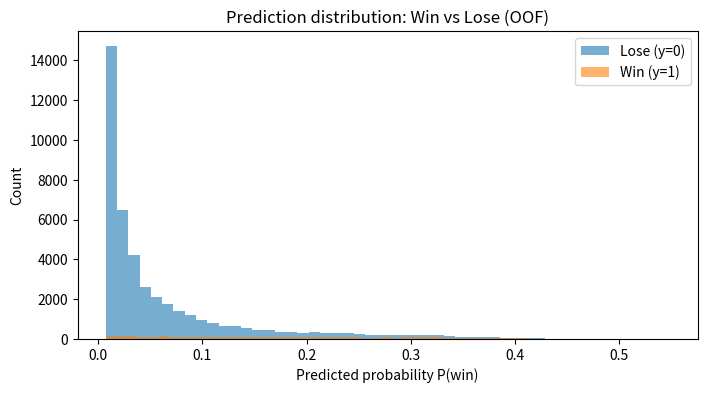

In [18]:
import matplotlib.pyplot as plt
import numpy as np

pos = df.loc[y==1, "pred_win"]
neg = df.loc[y==0, "pred_win"]

plt.figure(figsize=(8,4))
plt.hist(neg, bins=50, alpha=0.6, label="Lose (y=0)")
plt.hist(pos, bins=50, alpha=0.6, label="Win (y=1)")
plt.xlabel("Predicted probability P(win)")
plt.ylabel("Count")
plt.title("Prediction distribution: Win vs Lose (OOF)")
plt.legend()
plt.show()


/tmp/ipykernel_1619434/3801697642.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cal = tmp.groupby("bin").agg(


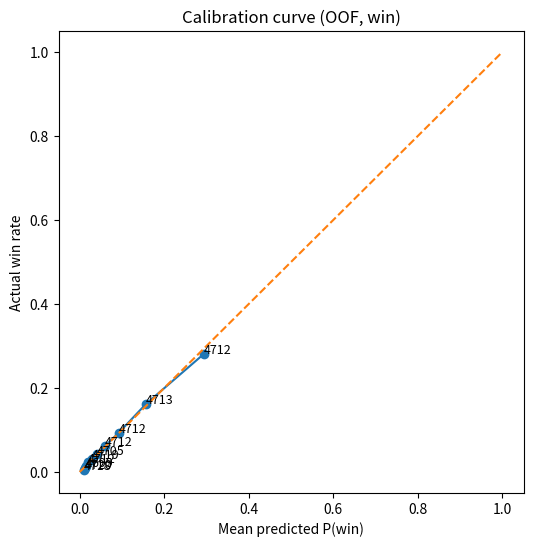

,p_mean,y_rate,n
0,0.009891,0.005723,4718
1,0.012563,0.008686,4720
2,0.015000,0.013833,4699
3,0.020220,0.023345,4712
4,0.028274,0.031574,4719
5,0.040142,0.041658,4705
6,0.060288,0.062394,4712
7,0.092284,0.093166,4712
8,0.156790,0.161893,4713
9,0.293755,0.280985,4712


In [19]:
import pandas as pd

tmp = pd.DataFrame({"p": df["pred_win"].values, "y": y.values if hasattr(y, "values") else np.asarray(y)})
tmp = tmp.dropna()

# ビン分割（等頻度）
tmp["bin"] = pd.qcut(tmp["p"], q=10, duplicates="drop")

cal = tmp.groupby("bin").agg(
    p_mean=("p","mean"),
    y_rate=("y","mean"),
    n=("y","size")
).reset_index(drop=True)

plt.figure(figsize=(6,6))
plt.plot(cal["p_mean"], cal["y_rate"], marker="o")
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("Mean predicted P(win)")
plt.ylabel("Actual win rate")
plt.title("Calibration curve (OOF, win)")
for i, r in cal.iterrows():
    plt.text(r["p_mean"], r["y_rate"], str(int(r["n"])), fontsize=9)
plt.show()

cal


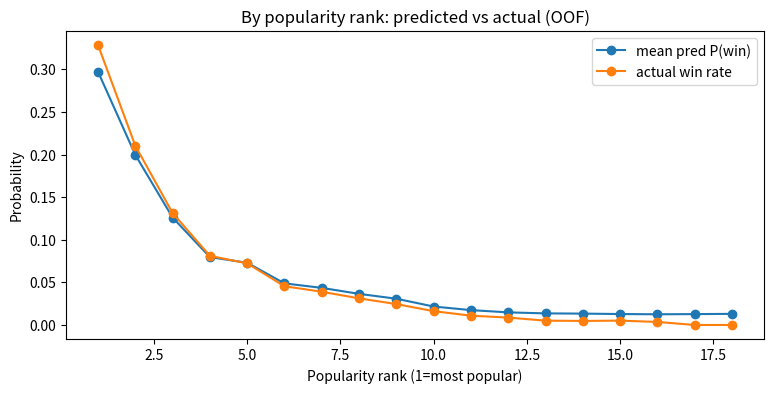

,_pop,n,pred_mean,win_rate
0,1.0,3402,0.297332,0.328630
1,2.0,3402,0.199720,0.210464
2,3.0,3402,0.126109,0.131393
3,4.0,3402,0.079678,0.081129
4,5.0,3402,0.072996,0.072310
5,6.0,3388,0.048825,0.045455
6,7.0,3360,0.043538,0.038988
7,8.0,3297,0.036503,0.031241
8,9.0,3180,0.030799,0.024528
9,10.0,3021,0.021646,0.016220


In [20]:
import pandas as pd

pop_col = "人 気"  # あなたのCSV列名に合わせてる

df["_pop"] = pd.to_numeric(df[pop_col], errors="coerce")

pop_stats = df.dropna(subset=["_pop", "pred_win"]).groupby("_pop").agg(
    n=("pred_win","size"),
    pred_mean=("pred_win","mean"),
    win_rate=(lambda s: (df.loc[s.index, y.name] if hasattr(y, "name") else df.loc[s.index, "y_win"]).mean(), "mean") if False else ("pred_win","mean")
)

# ↑上がややこしいので、確実版を作る
tmp2 = df[["_pop", "pred_win"]].copy()
tmp2["y"] = y.values if hasattr(y,"values") else np.asarray(y)

pop_stats = tmp2.dropna(subset=["_pop"]).groupby("_pop").agg(
    n=("y","size"),
    pred_mean=("pred_win","mean"),
    win_rate=("y","mean")
).reset_index().sort_values("_pop")

plt.figure(figsize=(9,4))
plt.plot(pop_stats["_pop"], pop_stats["pred_mean"], marker="o", label="mean pred P(win)")
plt.plot(pop_stats["_pop"], pop_stats["win_rate"], marker="o", label="actual win rate")
plt.xlabel("Popularity rank (1=most popular)")
plt.ylabel("Probability")
plt.title("By popularity rank: predicted vs actual (OOF)")
plt.legend()
plt.show()

pop_stats.head(15)


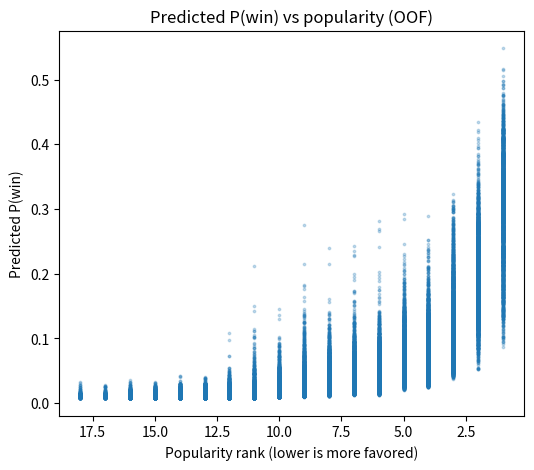

In [21]:
plt.figure(figsize=(6,5))
plt.scatter(df["_pop"], df["pred_win"], s=3, alpha=0.25)
plt.gca().invert_xaxis()  # 1番人気が左に来ると見やすい
plt.xlabel("Popularity rank (lower is more favored)")
plt.ylabel("Predicted P(win)")
plt.title("Predicted P(win) vs popularity (OOF)")
plt.show()


In [22]:
from sklearn.metrics import log_loss

# 人気だけの単純モデル：人気順位→固定確率（超粗いベースライン）
# 値はざっくり。後でデータから推定する版も作れる
def p_pop_only(pop):
    if pop == 1: return 0.33
    if pop == 2: return 0.18
    if pop == 3: return 0.12
    if pop == 4: return 0.09
    if pop == 5: return 0.07
    return 0.04

df["pred_pop_only"] = df["_pop"].apply(p_pop_only)

mask = df[["pred_win","pred_pop_only","_pop"]].notna().all(axis=1)
y_true = (y.values if hasattr(y,"values") else np.asarray(y))[mask.values]

print("LogLoss (LGB OOF):", log_loss(y_true, df.loc[mask,"pred_win"]))
print("LogLoss (pop-only):", log_loss(y_true, df.loc[mask,"pred_pop_only"]))


LogLoss (LGB OOF): 0.21660842762778557
LogLoss (pop-only): 0.21783891727280308


# 単勝バックテスト

In [24]:
import numpy as np
import pandas as pd

# -----------------------------
# 1) 勝ちフラグ y_win を用意
# -----------------------------
if "y_win" not in df.columns:
    if "y_place" in df.columns:
        # あなたのノートブックでは y_place = (着順==1) なので、そのまま流用OK
        df["y_win"] = df["y_place"].astype(int)
    else:
        # y_place も無い場合は、着順から作る
        df["着 順_num"] = pd.to_numeric(df.get("着 順"), errors="coerce")
        df["y_win"] = (df["着 順_num"] == 1).fillna(False).astype(int)

# -----------------------------
# 2) 予測確率 pred_win を用意（名前ゆれ対策）
# -----------------------------
if "pred_win" not in df.columns:
    # ありがちな代替名を順に拾う（必要なら追加して）
    for cand in ["pred_place", "oof_pred", "pred", "p_win"]:
        if cand in df.columns:
            df["pred_win"] = df[cand].astype(float)
            break
    else:
        raise KeyError("pred_win が無いです。モデルの予測列名（例: pred_place / oof_pred）を確認して下さい。")

# -----------------------------
# 3) 単勝オッズ odds_win（列名ゆれ対策）
# -----------------------------
odds_col = None
for cand in ["単勝", "単勝オッズ", "単勝_オッズ"]:
    if cand in df.columns:
        odds_col = cand
        break
if odds_col is None:
    raise KeyError("単勝オッズ列が見つかりません。df.columns を見て列名を合わせてください。")

df["odds_win"] = pd.to_numeric(df[odds_col], errors="coerce")

# -----------------------------
# 4) 必要な行だけ
# -----------------------------
need_cols = ["pred_win", "y_win", "odds_win"]
df_ev = df.dropna(subset=[c for c in need_cols if c in df.columns]).copy()

df_ev.head(), df_ev[need_cols].isna().sum()


(        race_id 着 順  枠 番  馬 番        馬名  性齢    斤量    騎手     タイム     着差  ...  \
 0  202501010101   1    3    3  ショウナンカリス  牝2  55.0  北村友一  1:08.9    NaN  ...   
 1  202501010101   2    4    4   ファニーバニー  牝2  55.0  鮫島克駿  1:09.1  1.1/4  ...   
 2  202501010101   3    2    2      ハルヒメ  牝2  52.0  小林美駒  1:09.1     ハナ  ...   
 3  202501010101   4    6    7   カンレイスター  牝2  55.0  荻野琢真  1:09.9      5  ...   
 4  202501010101   5    8   12    ココソラーレ  牝2  52.0  鷲頭虎太  1:10.1  1.1/4  ...   
 
         調教師    horse_id jockey_id 着 順_num  y_place  pred_win  _pop  \
 0  [東] 加藤士津  2023105347       NaN     1.0        1  0.110053   3.0   
 1  [西] 杉山佳明  2023105277       NaN     2.0        0  0.339152   1.0   
 2  [東] 矢嶋大樹  2023103400       NaN     3.0        0  0.152564   2.0   
 3  [東] 矢野英一  2023105558       NaN     4.0        0  0.014836   8.0   
 4  [東] 天間昭一  2023109031       NaN     5.0        0  0.010125  10.0   
 
    pred_pop_only  odds_win  y_win  
 0           0.12       4.8      1  
 1           0.3

In [25]:
import numpy as np
import pandas as pd

# 単勝オッズ（文字列対策）
df["odds_win"] = pd.to_numeric(df["単勝"], errors="coerce")

# 必要な行だけ
df_ev = df.dropna(subset=["pred_win", "y_win", "odds_win"]).copy()


# EVと実際の損益を計算

In [26]:
# EV
df_ev["EV"] = df_ev["pred_win"] * df_ev["odds_win"] - 1

# 実現損益
# 勝ったら (odds - 1), 負けたら -1
df_ev["profit"] = np.where(
    df_ev["y_win"] == 1,
    df_ev["odds_win"] - 1,
    -1
)


In [27]:
def backtest(ev_th):
    bet = df_ev["EV"] >= ev_th
    n = bet.sum()
    if n == 0:
        return n, np.nan, np.nan
    profit = df_ev.loc[bet, "profit"].sum()
    roi = profit / n
    hit = df_ev.loc[bet, "y_win"].mean()
    return n, roi, hit

ths = np.arange(-0.05, 0.31, 0.01)
rows = []
for t in ths:
    n, roi, hit = backtest(t)
    rows.append([t, n, roi, hit])

res = pd.DataFrame(rows, columns=["EV_th", "bets", "ROI", "hit_rate"])
res = res[res["bets"] >= 50]   # 少なすぎるのは除外
res.sort_values("ROI", ascending=False).head(10)


,EV_th,bets,ROI,hit_rate
0,-5.000000e-02,24065,-0.369786,0.035113
1,-4.000000e-02,23789,-0.373534,0.034596
2,-3.000000e-02,23505,-0.375422,0.034035
3,-2.000000e-02,23258,-0.376533,0.033494
4,-1.000000e-02,23011,-0.378376,0.032897
5,6.938894e-18,22750,-0.379007,0.032308
6,1.000000e-02,22498,-0.382190,0.031692
7,2.000000e-02,22270,-0.384320,0.030759
8,3.000000e-02,22018,-0.387274,0.030066
10,5.000000e-02,21564,-0.397436,0.029076
